# Preprocessor
This code combines all the FITS data cubes in the Cygnus-spur region into a single FITS data cube which is then saved.

In [1]:
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import numpy as np
import os

In [2]:
#Matplotlib configuration
from matplotlib import pyplot as plt

#A4 tufte layout paper figure sizes
MARGIN_FIG = lambda scale: (1.99, 1.99*scale)
MAIN_FIG = lambda scale: (4.18, 4.18*scale)
FULL_FIG = lambda scale: (6.64, 6.64*scale)

#Fontsize configuration
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', family='Fira Code')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#Other matplotlib configuration
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Fira Code'
plt.rcParams['mathtext.it'] = 'Fira Code'
plt.ioff()

In [5]:
CGPS_PATH = os.environ.get('CGPS_PATH')
DATA_PATH = os.environ.get('DATA_PATH')

def open_mozaïek(mozaïek) -> fits.HDUList:
  if CGPS_PATH is not None:
    return fits.open(f'{CGPS_PATH}/CGPS_{mozaïek}_HI_line_image.fits')
  else:
    #path = f"/home/raulwolters/Documents/CGPS_DataCubes/CGPS_{mozaïek}_HI_line_image.fits"
    path = f"H:\\CGPS_HI_DATACUBES\\CGPS_{mozaïek}_HI_line_image.fits"
    return fits.open(path)

def save_mozaïek(data, path):
  #create new FITS file
  hdu = fits.PrimaryHDU(data)
  hdu.writeto(path, overwrite=True)

In [6]:
hdus_M1 = open_mozaïek("MM1")
hdus_M2 = open_mozaïek("MM2")
hdus_N1 = open_mozaïek("MN1")
hdus_N2 = open_mozaïek("MN2")
hdus_O1 = open_mozaïek("MO1")
hdus_O2 = open_mozaïek("MO2")

In [7]:
REF_PX = 513 #reference px for location of image
PX_SIZE = 5e-3 #angular px size

#positions of the data cubes
POS_N1 = np.array([80.75, -1])
POS_N2 = np.array([80.75, 3])
POS_O1 = np.array([76.75, -1])
POS_O2 = np.array([76.75, 3])

delta_px_lat = (POS_N1 - POS_N2) / PX_SIZE
delta_px_long = (POS_O1 - POS_N1) / PX_SIZE

print(delta_px_lat, delta_px_long)

[   0. -800.] [-800.    0.]


In [8]:
#combineer de images
dpx = -int(delta_px_lat[1])
dpy = -int(delta_px_long[0])
img_size = 1024
full_image = np.zeros((272, img_size + dpy, img_size + (2*dpy)))

#y posities
m_start_y = 0
m_end_y = img_size
n_start_y = m_start_y + dpy
n_end_y = m_end_y + dpy
o_start_y = n_start_y + dpy
o_end_y = n_end_y + dpy

print(m_start_y, m_end_y, n_start_y, n_end_y, o_start_y, o_end_y)

#plot m1 aan linker kant
start_x1 = 0
end_x1 = 1024
full_image[:,start_x1:end_x1, m_start_y:m_end_y] = hdus_M1[0].data[0, :, :, :]

#plot m2 aan rechter kant
start_x2 = start_x1 - int(delta_px_lat[1])
end_x2 = end_x1 - int(delta_px_lat[1])
full_image[:, start_x2:end_x2, m_start_y:m_end_y] = hdus_M2[0].data[0, :, :, :]

#plot n1
full_image[:,start_x1:end_x1, n_start_y:n_end_y] = hdus_N1[0].data[0, :, :, :]

#plot n2
full_image[:, start_x2:end_x2, n_start_y:n_end_y] = hdus_N2[0].data[0, :, :, :]

#plot o1 rechtsboven
full_image[:,start_x1:end_x1, o_start_y:o_end_y] = hdus_O1[0].data[0, :, :, :]

#plot 02 rechtsonder
full_image[:,start_x2:end_x2, o_start_y:o_end_y] = hdus_O2[0].data[0, :, :, :]

0 1024 800 1824 1600 2624


Positie px (513, 513) van cube M1 is $(80,75^{\circ};0^{\circ})$, elke pixel is
precies $18''=5^{\circ}\times10^{-3}$

In [9]:
refx, refy = POS_N1[0], POS_N1[1]
def convert_degree(deg):
  degrees = np.trunc(deg).astype(int)
  minutes = np.abs(np.round(60*(degrees - deg))).astype(int)
  return [f"{d}°{m}'" for d, m in zip(degrees, minutes)]
def get_x_deg(x_px):
  deg = (x_px - 1313) * PX_SIZE + refx
  return convert_degree(deg)
def get_y_deg(y_px):
  deg = -(y_px - 1311) * PX_SIZE + refy
  return convert_degree(deg)

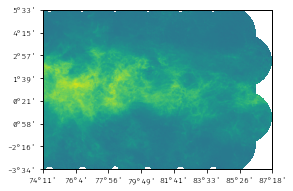

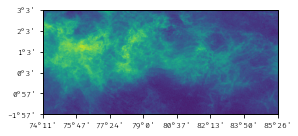

In [10]:
x_start, x_stop = 500, 1500
y_start, y_stop = 0, 2250

yticks = np.round(np.linspace(0, 1824, 8))
xticks = np.round(np.linspace(0, 2624, 8))

plt.figure(figsize=MAIN_FIG(0.85))
plt.imshow(full_image[130])
plt.yticks(yticks, get_y_deg(yticks))
plt.xticks(xticks, get_x_deg(xticks))

yticks = np.round(np.linspace(0, x_stop - x_start, 6))
xticks = np.round(np.linspace(0, y_stop - y_start, 8))

plt.figure(figsize=FULL_FIG(0.3))
plt.imshow(full_image[130, x_start:x_stop, y_start:y_stop])
plt.yticks(yticks, get_y_deg(yticks + x_start))
plt.xticks(xticks, get_x_deg(xticks + y_start))
plt.show()

#delete the old canvas
data_cube = full_image[:, x_start:x_stop, y_start:y_stop]
del full_image

In [11]:
#normalise all slices <- NEE!
#normaliseer de hele data cube, niet iedere slice los want dan marginaliseer je
#dus over de velocity axis you dumb dumb
cube_mean = np.nanmean(data_cube)
data_cube = (data_cube - cube_mean) / cube_mean
print(data_cube.shape)

(272, 1000, 2250)


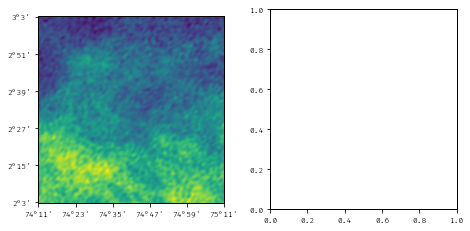

In [12]:
yticks = np.round(np.linspace(0, 200, 6)) #200px = 1 degree
xticks = np.round(np.linspace(0, 200, 6))

fig = plt.figure(figsize=FULL_FIG(0.5))
ax1, ax2 = fig.subplots(1, 2)
ax1.set_yticks(yticks, labels=get_y_deg(yticks + x_start))
ax1.set_xticks(xticks, labels=get_x_deg(xticks + y_start))
ax1.imshow(data_cube[130, :201, :201])

In [13]:
#convolve elk plane met een gaussian ter grootte van de beam size
beam_size = 3.3
for (idx, image) in enumerate(data_cube):
  data_cube[idx,...] = gaussian_filter(image, beam_size, order=0)

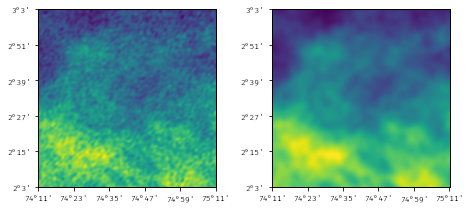

In [15]:
ax2.set_yticks(yticks, labels=get_y_deg(yticks + x_start))
ax2.set_xticks(xticks, labels=get_x_deg(xticks + y_start))
ax2.imshow(data_cube[130, :201, :201])
fig.savefig('../figs/smooth-unsmooth.pdf', transparent=True, bbox_inches="tight", pad_inches=0.05)
fig

In [16]:
if DATA_PATH is not None:
  path = f'{DATA_PATH}/full_cube_smoothed.fits'
else:
  path = "../tmp/full_cube_smoothed.fits"
save_mozaïek(data_cube, path)

# Dezelfde code, andere richting!

In [17]:
del hdus_M1, hdus_M2, hdus_N1, hdus_N2, hdus_O1, hdus_O2
hdus_A1 = open_mozaïek("MA1")
hdus_A2 = open_mozaïek("MA2")
hdus_B1 = open_mozaïek("MB1")
hdus_B2 = open_mozaïek("MB2")
hdus_C1 = open_mozaïek("MC1")
hdus_C2 = open_mozaïek("MC2")

In [18]:
REF_PX = 513 #reference px for location of image
PX_SIZE = 5e-3 #angular px size

#positions of the data cubes
POS_A1 = np.array([128.75, -1])
POS_A2 = np.array([POS_A1[0], 3])
POS_B1 = np.array([124.75, -1])
POS_B2 = np.array([POS_B1[0], 3])
POS_C1 = np.array([120.75, -1])
POS_C2 = np.array([POS_C1[0], 3])

delta_px_lat = (POS_A1 - POS_A2) / PX_SIZE
delta_px_long = (POS_B1 - POS_A1) / PX_SIZE

In [19]:
#combineer de images
dpx = -int(delta_px_lat[1])
dpy = -int(delta_px_long[0])
img_size = 1024
full_image = np.zeros((272, img_size + dpy, img_size + (2*dpy)))

#y posities
a_start_y = 0
a_end_y = img_size
b_start_y = a_start_y + dpy
b_end_y = a_end_y + dpy
c_start_y = b_start_y + dpy
c_end_y = b_end_y + dpy

print(a_start_y, a_end_y, b_start_y, b_end_y, c_start_y, c_end_y)

#plot m1 aan linker kant
start_x1 = 0
end_x1 = 1024
full_image[:,start_x1:end_x1, a_start_y:a_end_y] = hdus_A1[0].data[0, :, :, :]

#plot m2 aan rechter kant
start_x2 = start_x1 - int(delta_px_lat[1])
end_x2 = end_x1 - int(delta_px_lat[1])
full_image[:, start_x2:end_x2, a_start_y:a_end_y] = hdus_A2[0].data[0, :, :, :]

#plot n1
full_image[:,start_x1:end_x1, b_start_y:b_end_y] = hdus_B1[0].data[0, :, :, :]

#plot n2
full_image[:, start_x2:end_x2, b_start_y:b_end_y] = hdus_B2[0].data[0, :, :, :]

#plot o1 rechtsboven
full_image[:,start_x1:end_x1, c_start_y:c_end_y] = hdus_C1[0].data[0, :, :, :]

#plot 02 rechtsonder
full_image[:,start_x2:end_x2, c_start_y:c_end_y] = hdus_C2[0].data[0, :, :, :]

print(start_x1, end_x1, start_x2, end_x2)

0 1024 800 1824 1600 2624
0 1024 800 1824


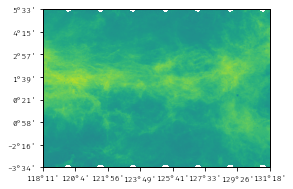

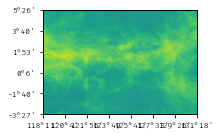

In [20]:
refx, refy = POS_B1[0], POS_B1[1]
x_start, x_stop = 24, 1800
y_start, y_stop = 0, 2624

yticks = np.round(np.linspace(0, 1824, 8))
xticks = np.round(np.linspace(0, 2624, 8))

plt.figure()
plt.imshow(full_image[130])
plt.yticks(yticks, get_y_deg(yticks))
plt.xticks(xticks, get_x_deg(xticks))

yticks = np.round(np.linspace(0, x_stop - x_start, 6))
xticks = np.round(np.linspace(0, y_stop - y_start, 8))

plt.figure()
plt.imshow(full_image[130, x_start:x_stop, y_start:y_stop])
plt.yticks(yticks, get_y_deg(yticks + x_start))
plt.xticks(xticks, get_x_deg(xticks + y_start))
plt.show()

#delete the old canvas
data_cube = full_image[:, x_start:x_stop, y_start:y_stop]
del full_image

In [21]:
#normalise all slices <- NEE!
#normaliseer de hele data cube, niet iedere slice los want dan marginaliseer je
#dus over de velocity axis you dumb dumb
cube_mean = np.nanmean(data_cube)
data_cube = (data_cube - cube_mean) / cube_mean
print(data_cube.shape)

(272, 1776, 2624)


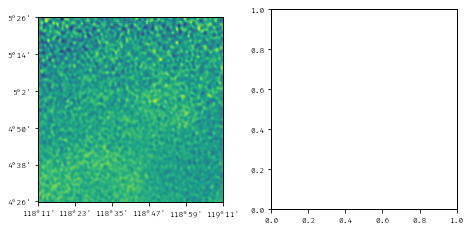

In [22]:
yticks = np.round(np.linspace(0, 200, 6)) #200px = 1 degree
xticks = np.round(np.linspace(0, 200, 6))

fig = plt.figure(figsize=FULL_FIG(0.5))
ax1, ax2 = fig.subplots(1, 2)
ax1.set_yticks(yticks, labels=get_y_deg(yticks + x_start))
ax1.set_xticks(xticks, labels=get_x_deg(xticks + y_start))
ax1.imshow(data_cube[130, :201, :201])

In [23]:
#convolve elk plane met een gaussian ter grootte van de beam size
beam_size = 3.3
for (idx, image) in enumerate(data_cube):
  data_cube[idx,...] = gaussian_filter(image, beam_size, order=0)

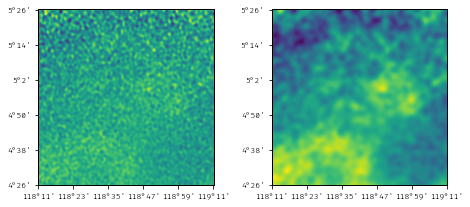

In [24]:
ax2.set_yticks(yticks, labels=get_y_deg(yticks + x_start))
ax2.set_xticks(xticks, labels=get_x_deg(xticks + y_start))
ax2.imshow(data_cube[130, :201, :201])

fig.savefig('../figs/smooth-unsmooth-farfield.pdf', transparent=True, bbox_inches="tight", pad_inches=0.05)
fig

In [25]:
if DATA_PATH is not None:
  path = f'{DATA_PATH}/full_cube_smoothed-farfield.fits'
else:
  path = "../tmp/full_cube_smoothed-farfield.fits"
save_mozaïek(data_cube, path)